# Курсовой проект "Введение в нейронные сети"


## 1. Обучить нейросеть

Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети


Обучу [BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en) на датасете IMDB (a sentiment analysis)

### Setup


In [4]:
# A dependency of the preprocessing for BERT inputs
# !pip install -q -U "tensorflow-text==2.8.*"

In [3]:
# !pip install tf-models-official==2.7.0

In [5]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

### Download the IMDB dataset

In [6]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 232s 3us/step


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-07-16 21:48:12.433127: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [21]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})\n')

Review: b"My children watch the show everyday that its on. Its a great program for younger children. However they need to stop showing re-runs and do some more actual shows and get rid of Rooney's and Deedee's YELLOW TEETH. Moe is the only Doodle bop with clean white pearlie teeth and the children notice these things and ask if the 2 don't ever brush their teeth? Does the show ever make its way to the United States and if so where can we find its schedule at. And one other thing if we might be able to add. Moe you need to stop hiding so much. Sometimes when you pop up out of no where you scare the younger children and whats with the pulling of the rope? What does that signify? other then getting wet all the time. They need to add newer things to their show instead of the same ole same ole. Kids loose interest that way."
Label : 0 (neg)

Review: b'I just got this video used and I was watching it last night. The acting started out extremely bad (hey------hey------twister) but got very go

2022-07-16 21:52:46.694094: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Loading models from TensorFlow Hub

TF позволяет выбрать много разных версий моделей BERT. Я выбрал Small BERT

In [22]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### The preprocessing model

In [23]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [24]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Using the BERT model


In [25]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [26]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626287   0.99280983 -0.18611823  0.3667384   0.15233725  0.6550442
  0.9681154  -0.948627    0.0021617  -0.9877732   0.0684269  -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321266  0.33231547 ...  0.2130081   0.71020746
  -0.05771154]
 [-0.28742057  0.31980976 -0.23018584 ...  0.5845509  -0.21329743
   0.7269206 ]
 [-0.6615704   0.68876845 -0.87433034 ...  0.10877228 -0.2617323
   0.47855324]
 ...
 [-0.22561148 -0.28925583 -0.07064399 ...  0.47566003  0.83277017
   0.4002542 ]
 [-0.2982427  -0.2747311  -0.05450499 ...  0.48849723  1.0955354
   0.18163374]
 [-0.44378164  0.0093075   0.07223718 ...  0.17290066  1.1833248
   0.07898001]]


### Define model

In [27]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [28]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.71797395]], shape=(1, 1), dtype=float32)


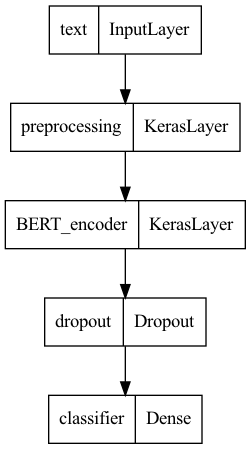

In [29]:
tf.keras.utils.plot_model(classifier_model)

### Loss function and Optimizer

In [30]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [31]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

In [32]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [33]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 1644s 3s/step - loss: 0.4836 - binary_accuracy: 0.7492 - val_loss: 0.3683 - val_binary_accuracy: 0.8382
Epoch 2/5
625/625 [==============================] - 1626s 3s/step - loss: 0.3310 - binary_accuracy: 0.8509 - val_loss: 0.3639 - val_binary_accuracy: 0.8490
Epoch 3/5
625/625 [==============================] - 1617s 3s/step - loss: 0.2554 - binary_accuracy: 0.8938 - val_loss: 0.4014 - val_binary_accuracy: 0.8482
Epoch 4/5
625/625 [==============================] - 2863s 5s/step - loss: 0.1940 - binary_accuracy: 0.9244 - val_loss: 0.4421 - val_binary_accuracy: 0.8536
Epoch 5/5
625/625 [==============================] - 1626s 3s/step - loss: 0.1492 - binary_accuracy: 0.9428 - val_loss: 0.4769 - val_binary_accuracy: 0.8518


### Evaluate the model

In [34]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 622s 795ms/step - loss: 0.4506 - binary_accuracy: 0.8559
Loss: 0.45063066482543945
Accuracy: 0.8558800220489502


### Plot the accuracy and loss over time

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


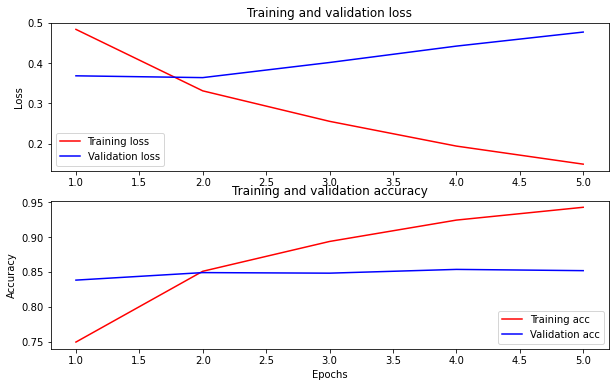

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Export for inference

In [36]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2022-07-17 09:56:32.810396: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [37]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [38]:
def print_my_examples(inputs, results):
    result_for_printing = \
        [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999492
input: The movie was great!           : score: 0.995206
input: The movie was meh.             : score: 0.967271
input: The movie was okish.           : score: 0.063164
input: The movie was terrible...      : score: 0.001182

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999492
input: The movie was great!           : score: 0.995207
input: The movie was meh.             : score: 0.967271
input: The movie was okish.           : score: 0.063164
input: The movie was terrible...      : score: 0.001182



## 2. Краткий обзор

Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?

### BERT

[Pre-training of Deep Bidirectional Transformers for Language Understanding (arxiv.org)](https://arxiv.org/abs/1810.04805)